### Fast Fourier Transform (FFT) - Decimação no Tempo

O propósito deste relatório é apresentar, ilustrar e exemplificar o renomado algoritmo FFT (Fast Fourier Transform). Este algoritmo faz uso da Transformada Discreta de Fourier (DFT) e ostenta uma complexidade temporal de **$O(n^2)$** em sua implementação.

In [14]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

### Revisão da Transformada Discreta de Fourier (DFT)

A definição da DFT é a seguinte:

$$\begin{equation}
X_k = \sum^{N-1}_{n=0}x_n \cdot e^{-j\frac{2\pi}{N}kn}
\end{equation}\tag1 $$

,que pode ser expandida com a fórmula de Euler para

$$\begin{equation}
X_k = \sum^{N-1}_{n=0}x_n \cdot (\cos{\frac{2\pi}{N}kn} - j \sin{\frac{2\pi}{N}kn})
\end{equation}\tag2$$

Também podemos escrever o termo exponencial na forma de matriz da DFT.

### Forma Matricial da DFT

$$\begin{equation}
e^{-j\frac{2\pi}{N}kn} = W_N^{nk}
\end{equation}\tag3$$

De maneira simples, W é uma matriz N por N, na qual cada linha é multiplicada pelo vetor x e somada para obter o ponto de dados transformado.

Agora, a versão da DFT em operação de matriz se parece com:

$$\begin{equation}
X_k = \sum_{n=0}^{N-1} x_n W_N^{nk} = W_N \cdot x
\end{equation}\tag4$$

$$\begin{equation}
\begin{bmatrix}
X_0 \\
X_1 \\
X_2 \\
X_3
\end{bmatrix}=
\begin{bmatrix}
W^{00} & W^{01} & W^{02} & W^{03} \\
W^{10} & W^{11} & W^{12} & W^{13} \\
W^{20} & W^{21} & W^{22} & W^{23} \\
W^{30} & W^{31} & W^{32} & W^{33} \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3
\end{bmatrix}
\end{equation}\tag5$$

A coisa importante a entender aqui é que a matriz W não depende do vetor de valores x, mas apenas dos índices inteiros n e k. Aqui podemos ver imediatamente uma melhoria, os valores nk e kn devem ser idênticos para a matriz W.

Podemos escrever a matriz W de forma explícita para um conjunto de dados simples com N = 4. Use Python para isso:


In [74]:
N = 64
W = np.zeros((N,N))* (0+0j)

## Naive (n^2) filling of W matrix
for k in range(N):
    for n in range(N):
        W[k,n] = np.exp(complex(0, -2*np.pi/N*k*n))

print(W.round(0))

[[1.-0.j 1.-0.j 1.-0.j ... 1.-0.j 1.-0.j 1.-0.j]
 [1.-0.j 1.-0.j 1.-0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.-0.j ... 1.+1.j 1.+0.j 1.+0.j]
 ...
 [1.-0.j 1.+0.j 1.+1.j ... 1.-1.j 1.-1.j 1.-0.j]
 [1.-0.j 1.+0.j 1.+0.j ... 1.-1.j 1.-0.j 1.-0.j]
 [1.-0.j 1.+0.j 1.+0.j ... 1.-0.j 1.-0.j 1.-0.j]]


$$\begin{equation}
W_N^{nk} = e^{-j\frac{2\pi}{N}kn} =
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & -j & -1 & j \\
1 & -1 & 1 & -1 \\
1 & j & -1 & -j \\
\end{bmatrix}
\end{equation}\tag6$$

Aqui podemos confirmar que a matriz é simétrica em relação à diagonal, dependendo apenas dos valores de k e n. A matriz W pode ter apenas N valores diferentes, portanto, o cálculo dos valores necessários pode ser facilmente otimizado para O(n). Note que aqui podemos obter a DFT simplesmente multiplicando a matriz W pelo vetor de entrada x.

Agora sabemos que podemos otimizar o algoritmo pela metade em relação à matriz W, mas ainda obtemos um tempo de computação de O(n²) porque ainda precisamos calcular o produto da matriz W pelo vetor x. Portanto, isso não resolve realmente nada. Mas isso nos mostrou a redundância que existe, agora só precisamos eliminá-la.

### Divisão dos dados de entrada

Para simplificar, começamos assumindo que os dados contêm $n^2$ valores. Um algoritmo de divisão e conquista pode ser usado para reduzir drasticamente a quantidade de cálculos necessários. A abordagem se baseia em dividir os dados de entrada em dois grupos, valores pares e ímpares, ambos com N/2 valores.

$$\begin{equation}
X_k = E_k + W^k_N O_k
\end{equation}\tag7$$

Onde E corresponde à equação para os valores pares e O aos valores ímpares.

Para os valores pares:

$$\begin{equation}
E_k = \sum_{n=0}^{N/2-1}x_{2n}W_{N}^{2kn}
\end{equation}\tag8$$

e para os valores ímpares:

$$\begin{equation}
O_{k} = \sum_{n=0}^{N/2-1}x_{2n+1}W_{N}^{(2n+1)k}
\end{equation}\tag9$$

O detalhe mais importante está na indexação da matriz W, como notamos anteriormente, a indexação da matriz W depende apenas dos valores de k e n. Vamos ver o que isso significa nos termos exponenciais.

A indexação para os valores pares:

$$\begin{equation}
W_{N}^{2kn} = e^{-j\frac{2\pi}{N}2kn} = e^{-j\frac{2}{\pi}2kn}= W_{N/2}^{kn}
\end{equation}\tag{10}$$

Para a indexação dos valores ímpares:

$$\begin{equation}
W_{N}^{(2n+1)k} = e^{-j\frac{2\pi}{N}(2n+1)k} = e^{-j\frac{2\pi}{N/2}kn}e^{-j\frac{2\pi}{N}k} = W_{N/2}^{kn}W_{N}^k
\end{equation}\tag{11}$$

Isso significa que reduzimos efetivamente o tamanho da matriz W de N x N para N/2 x N/2! Agora está claro que repetir esse processo leva a uma diminuição logarítmica do tamanho.

Agora fazemos isso até que N/2 = 2, e a divisão e conquista está pronta. As matrizes W agora são tão pequenas que pré-calcular os valores é trivial. Também podemos explorar ainda mais a natureza simétrica da matriz W, pois devido à conjugação complexa, a metade final do vetor $W_k^N$ é igual à negativa da primeira metade. Para nossa DFT dividida, isso significa:

Primeira metade:

$$\begin{equation}
X_k = E_n + W^k_N O_n, k<N/2
\end{equation}\tag{12}$$

Segunda metade:

$$\begin{equation}
X_k = E_n - W^k_N O_n, k>=N/2
\end{equation}\tag{13}$$

Então, podemos simplesmente concatenar os dois vetores $X_n$.

Observe que aqui estamos assumindo que o tamanho N é uma potência de dois. Estamos prontos para implementar o algoritmo usando recursão.

In [75]:
def naiveFFT(x):
    ''' The naive implementation for comparison '''
    N = x.size
    X = np.ones(N)*(0+0j)

    for k in range(N):
        A = np.ones(N)*(0+0j)
        for n in range(N):
            A[n] = x[n]*np.exp(-complex(0, 2*np.pi*k*n/N))
        X[k] = sum(A)

    return X

In [76]:
def FFT(x):
    ''' Recursive radix-2 FFT'''
    x = np.array(x, dtype=float)
    N = int(x.size)
    # Use the naive version when the size is small enough
    if N <= 8:
        return naiveFFT(x)
    else:
        # Calculate first half of the W veco
        k = np.arange(N//2)
        W = np.exp(-2j*np.pi*k/N)
        evens = FFT(x[::2])
        odds = FFT(x[1::2])
        return np.concatenate([evens + (W * odds), evens - (W * odds)])

    return 0

Assim, graficamente temos:

C:\Users\felip\AppData\Local\Temp\ipykernel_13520\2105719276.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.array(x, dtype=float)


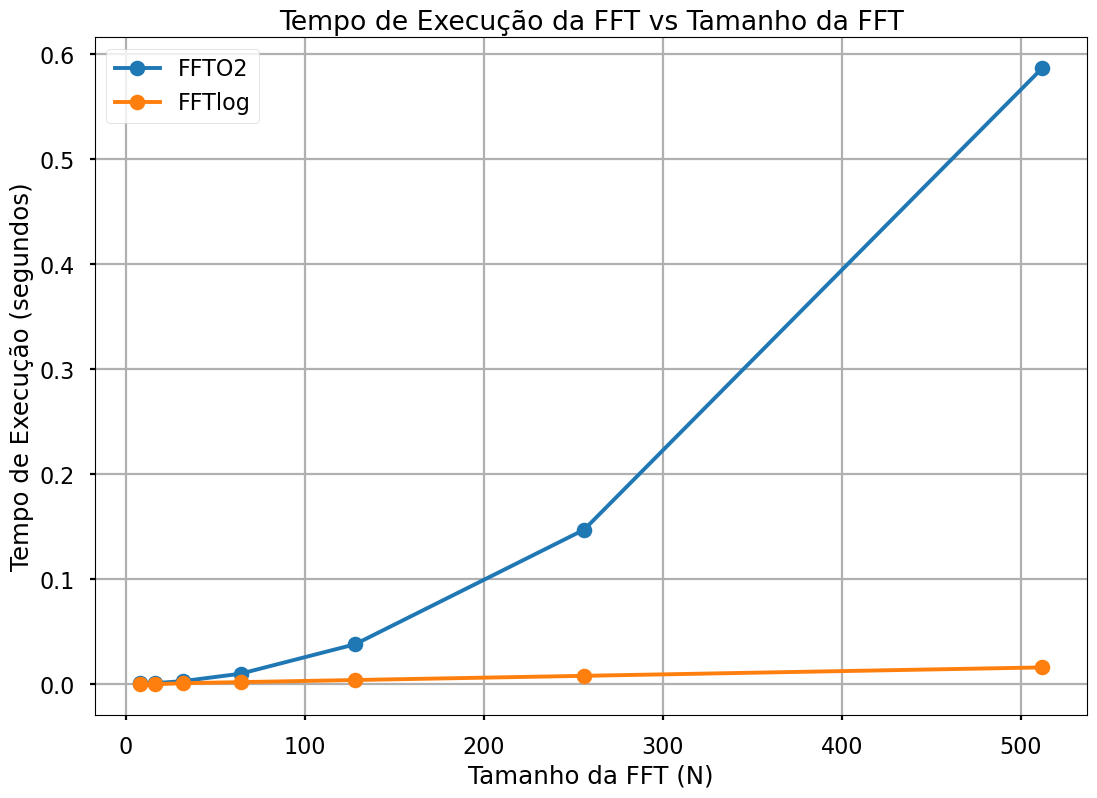

In [77]:
sizes = [8, 16, 32, 64, 128, 256, 512]

# Listas para armazenar os tempos de execução de naiveFFT e FFT
runtimes_naiveFFT = []
runtimes_FFT = []

for N in sizes:
    # Gerar um sinal de teste aleatório
    x = np.random.rand(N) + 1j * np.random.rand(N)
    
    # Medir o tempo de execução para naiveFFT
    start_time = time.time()
    naiveFFT(x)
    end_time = time.time()
    
    # Calcular o tempo decorrido
    runtime = end_time - start_time
    runtimes_naiveFFT.append(runtime)

    # Medir o tempo de execução para FFT
    start_time = time.time()
    FFT(x)
    end_time = time.time()
    
    # Calcular o tempo decorrido
    runtime = end_time - start_time
    runtimes_FFT.append(runtime)

# Plotar os gráficos do tempo de execução
plt.plot(sizes, runtimes_naiveFFT, marker='o', label='FFTO2')
plt.plot(sizes, runtimes_FFT, marker='o', label='FFTlog')
plt.title('Tempo de Execução da FFT vs Tamanho da FFT')
plt.xlabel('Tamanho da FFT (N)')
plt.ylabel('Tempo de Execução (segundos)')
plt.legend()
plt.grid(True)
plt.show()

Algoritmos:

1. Goertzel(1958): $O(N^2)$
2. Cooley-Tukey(1965): Deu origem à decimação no tempo

Esses algoritmos ficaram conhecidos como Transformada Rápida de Fourier, ou simplesmente FFT de Fast Fourier Transform.

In [87]:
def dft_matrix(N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N)
    return W

def dft(x):
    N = len(x)
    W = dft_matrix(N)
    return np.dot(W, x)


C:\Users\felip\AppData\Local\Temp\ipykernel_13520\2105719276.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.array(x, dtype=float)


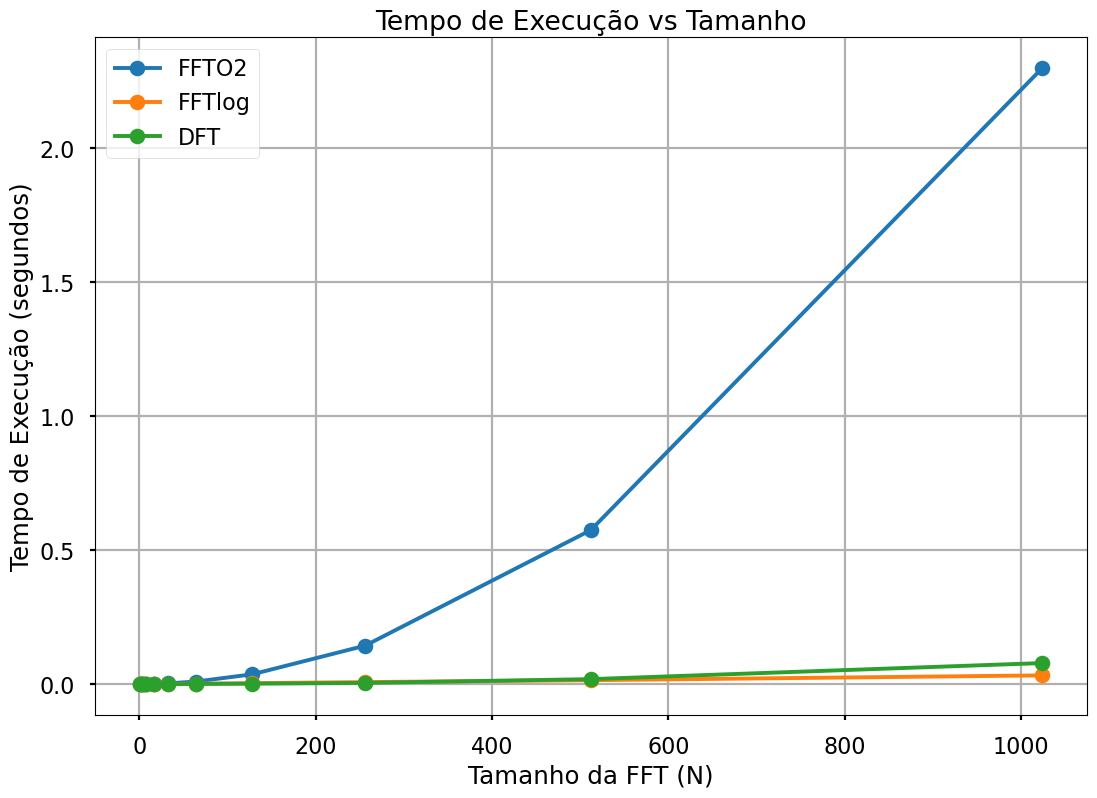

In [91]:
sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Listas para armazenar os tempos de execução de naiveFFT e FFT
runtimes_naiveFFT = []
runtimes_FFT = []
runtimes_dft = []

for N in sizes:
    # Gerar um sinal de teste aleatório
    x = np.random.rand(N) + 1j * np.random.rand(N)
    
    # Medir o tempo de execução para naiveFFT
    start_time = time.time()
    naiveFFT(x)
    end_time = time.time()
    
    # Calcular o tempo decorrido
    runtime = end_time - start_time
    runtimes_naiveFFT.append(runtime)

    # Medir o tempo de execução para FFT
    start_time = time.time()
    FFT(x)
    end_time = time.time()
    
    # Calcular o tempo decorrido
    runtime = end_time - start_time
    runtimes_FFT.append(runtime)

    # Medir o tempo de execução para FFT
    start_time = time.time()
    dft(x)
    end_time = time.time()
    
    # Calcular o tempo decorrido
    runtime = end_time - start_time
    runtimes_dft.append(runtime)
    
# Plotar os gráficos do tempo de execução
plt.plot(sizes, runtimes_naiveFFT, marker='o', label='FFTO2')
plt.plot(sizes, runtimes_FFT, marker='o', label='FFTlog')
plt.plot(sizes, runtimes_dft, marker='o', label='DFT')
plt.title('Tempo de Execução vs Tamanho')
plt.xlabel('Tamanho da FFT (N)')
plt.ylabel('Tempo de Execução (segundos)')
plt.legend()
plt.grid(True)
plt.show()